# Summary of HV1 Automated Baseline Correction

*This notebook is a partial copy of `HV1_Calibration.ipynb`.*

The purpose of this notebook is to summarize the first attempt at automated baseline correction for HV data.

## Setup

In [1]:
#Imports
import glob, math
import numpy as np
import pandas as pd
import lmfit as lf
import statistics as s
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from scipy import signal as sig
import uproot

#Import custom library included in this repository
import R76Tools as R76 

#Use local mplstyle
plt.style.use('classic')

We begin by loading in our data set:

In [2]:
datapath = "/data/chocula/fritts/data/k100proc/midasrq/byseries/" #Directory containing all series directories listed in `ser` below.
ser = "07220827_1153" #For this notebook we are currently only using one series.
e,z=0,0
filelist = glob.glob(datapath+ser+"/umn*.root")   #find all umn root files in series
filepath = datapath+ser
if not filelist: #if the file list comes back empty, you are probably missing files.
    raise ValueError("No data can be loaded for series %s! Do you have all the files?".format(x))
e,z = R76.makechain(filepath,R76.fittingfilters) #and import their data to two chains
z = pd.concat([z,e],axis=1) #Tack the corresponding entry in e to the right.
del e #we no longer need e, so delete it from memory.

Now we make some common shorthands available to us.

In [3]:
#We could also call these functions instead of importing them to memory, 
#but since we will probably call them multiple times, I am saving on computing time.
#I am also not storing them inside z this time because there is only one df of interest
crand = R76.crand(z)
pt_keV = R76.pt_keV(z)
cam = R76.cam(z)
cphi1 = R76.cphi1(z)
PSUMbs = R76.PSUMbs(z)

Now let's take a look at our data before and after cuts are made.

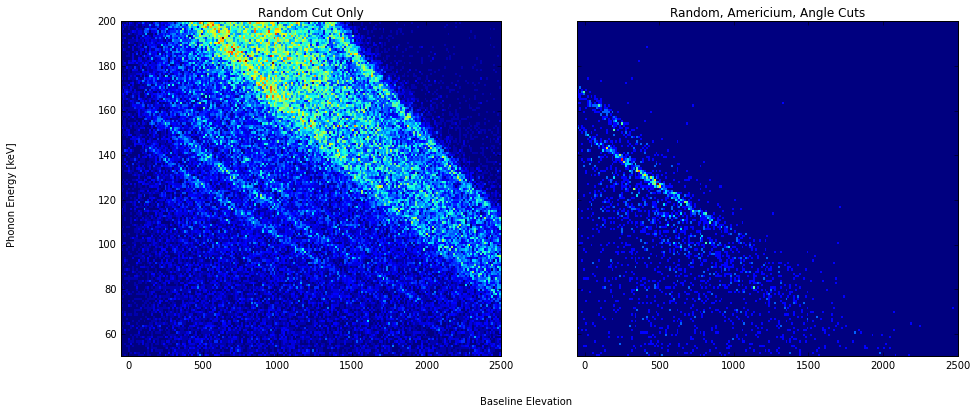

In [8]:
fig,ax = plt.subplots(1,2,figsize=(15,6),sharey=True) #set up plotting space

ax[0].hist2d(PSUMbs[~crand]-18000,pt_keV[~crand], #still cut out randoms
             bins=[np.linspace(-50,2500,200),np.linspace(50,200,150)])
ax[1].hist2d(PSUMbs[~crand & cam & cphi1]-18000,  #also cut for a small angle
             pt_keV[~crand & cam & cphi1],        #and americium ratio
             bins=[np.linspace(-50,2500,200),np.linspace(50,200,150)])
ax[0].set_title("Random Cut Only")
ax[1].set_title("Random, Americium, Angle Cuts")
fig.supxlabel("Baseline Elevation")
fig.supylabel("Phonon Energy [keV]")
plt.show()

## Manual Fit

Let's start with a manual fit. We'll take the clear line that we see on the right-hand plot and attempt to correct for the baseline.

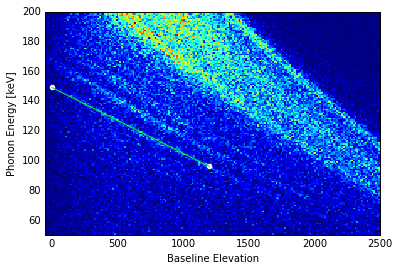

In [9]:
fig = plt.figure()
plt.hist2d(PSUMbs[~crand]-18000, pt_keV[~crand],
             bins=[np.linspace(-50,2500,200),np.linspace(50,200,150)])
points = [[0,149],[1200,96]]; 
m = (points[1][1]-points[0][1])/(points[1][0]-points[0][0]); b = points[0][1]
x = np.linspace(points[0][0],points[1][0],1000)
plt.scatter([points[0][0],points[1][0]],[points[0][1],points[1][1]],color='white')
plt.plot(x,m*x+b,color='lime')
plt.xlabel("Baseline Elevation")
plt.ylabel("Phonon Energy [keV]")
plt.show()

Now we program in that manual fit and take a look at the result.

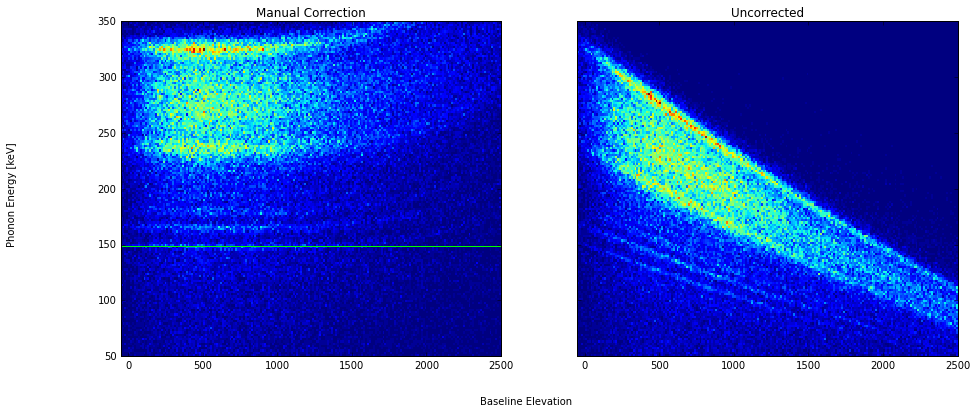

In [11]:
bscorr_man = pt_keV/(1.+(PSUMbs-18000.)*m/b)
    
#Now plot it against the uncorrected version.
fig,ax = plt.subplots(1,2,figsize=(15,6),sharey=True) #set up plotting space

fig.supxlabel("Baseline Elevation")
fig.supylabel("Phonon Energy [keV]")
ax[1].hist2d(PSUMbs[~crand]-18000,pt_keV[~crand],
             bins=[np.linspace(-50,2500,200),np.linspace(50,350,150)])
ax[0].hist2d(PSUMbs[~crand]-18000,bscorr_man[~crand],
             bins=[np.linspace(-50,2500,200),np.linspace(50,350,150)])
ax[0].axhline(149,color='lime')
ax[0].set_title("Manual Correction")
ax[1].set_title("Uncorrected")
plt.show()

So we would need to do another correction if we wanted to go past 1000. The manual fit is not bad, and doesn't take too long, but if we are going to be doing many of these, it may be nice to have them automated.

## Automated Fit

Now let's do an automated fit using those cuts we made earlier. First, let's take a look at our data in scatter form:

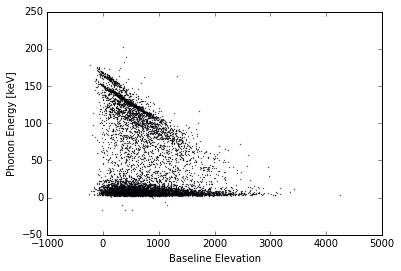

In [10]:
fig = plt.figure()

plt.scatter(PSUMbs[~crand & cphi1 & cam]-18000,
            pt_keV[~crand & cphi1 & cam],
            s=0.1) #Very many points, so make them small so we can see them better

plt.xlabel("Baseline Elevation")
plt.ylabel("Phonon Energy [keV]")

plt.show()

We have a huge chunk of values at the bottom that are obviously not part of our line of interest; 
let's cut them out of our fit. `y=50` seems like a good place to cut, being both well above the cluster and well below the line we want to fit.

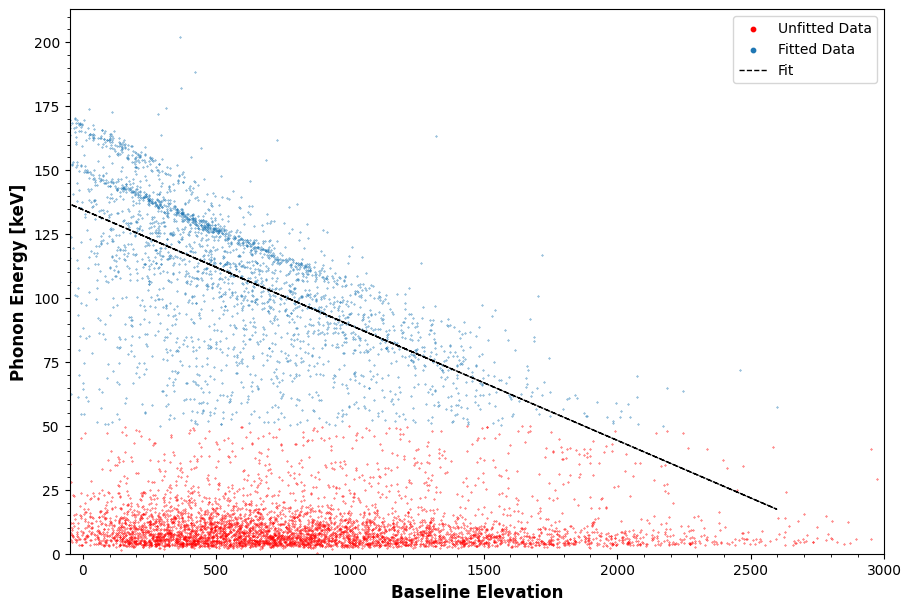

In [8]:
def f(x,m=m,b=b): return m*x+b #Define the equation of a line for fitting.

#Define our data points with our new y > 50 fit
x = PSUMbs[~crand & cphi1 & cam & (pt_keV>50)]-18000
y = pt_keV[~crand & cphi1 & cam & (pt_keV>50)]

#Set up to fit
mod = lf.Model(f); params = mod.make_params()
params.add('m',value=-0.2,max=0,min=-1);params.add('b',value=150,min=0) #give reasonable constraints
fit = mod.fit(y,params,x=x)

fig = plt.figure()

plt.scatter(PSUMbs[~crand & cphi1 & cam & (pt_keV<50)]-18000,
            pt_keV[~crand & cphi1 & cam & (pt_keV<50)],
            s=0.1,color='red',label='Unfitted Data')
plt.scatter(x,y,s=0.1,label='Fitted Data')
plt.plot(x,fit.best_fit,color='k',linewidth=1,label="Fit")

plt.xlabel("Baseline Elevation",weight="bold",fontsize=12)
plt.ylabel("Phonon Energy [keV]",weight="bold",fontsize=12)
plt.xlim(-50,3000); plt.ylim(0)
plt.legend()
plt.show()

fit

We see that the slope looks good, but we don't quite reach the right intercept. It looks, however, like our intercept should be the most common value at 0, so let's see if we can't get that another way and find out what the new results look like from there.

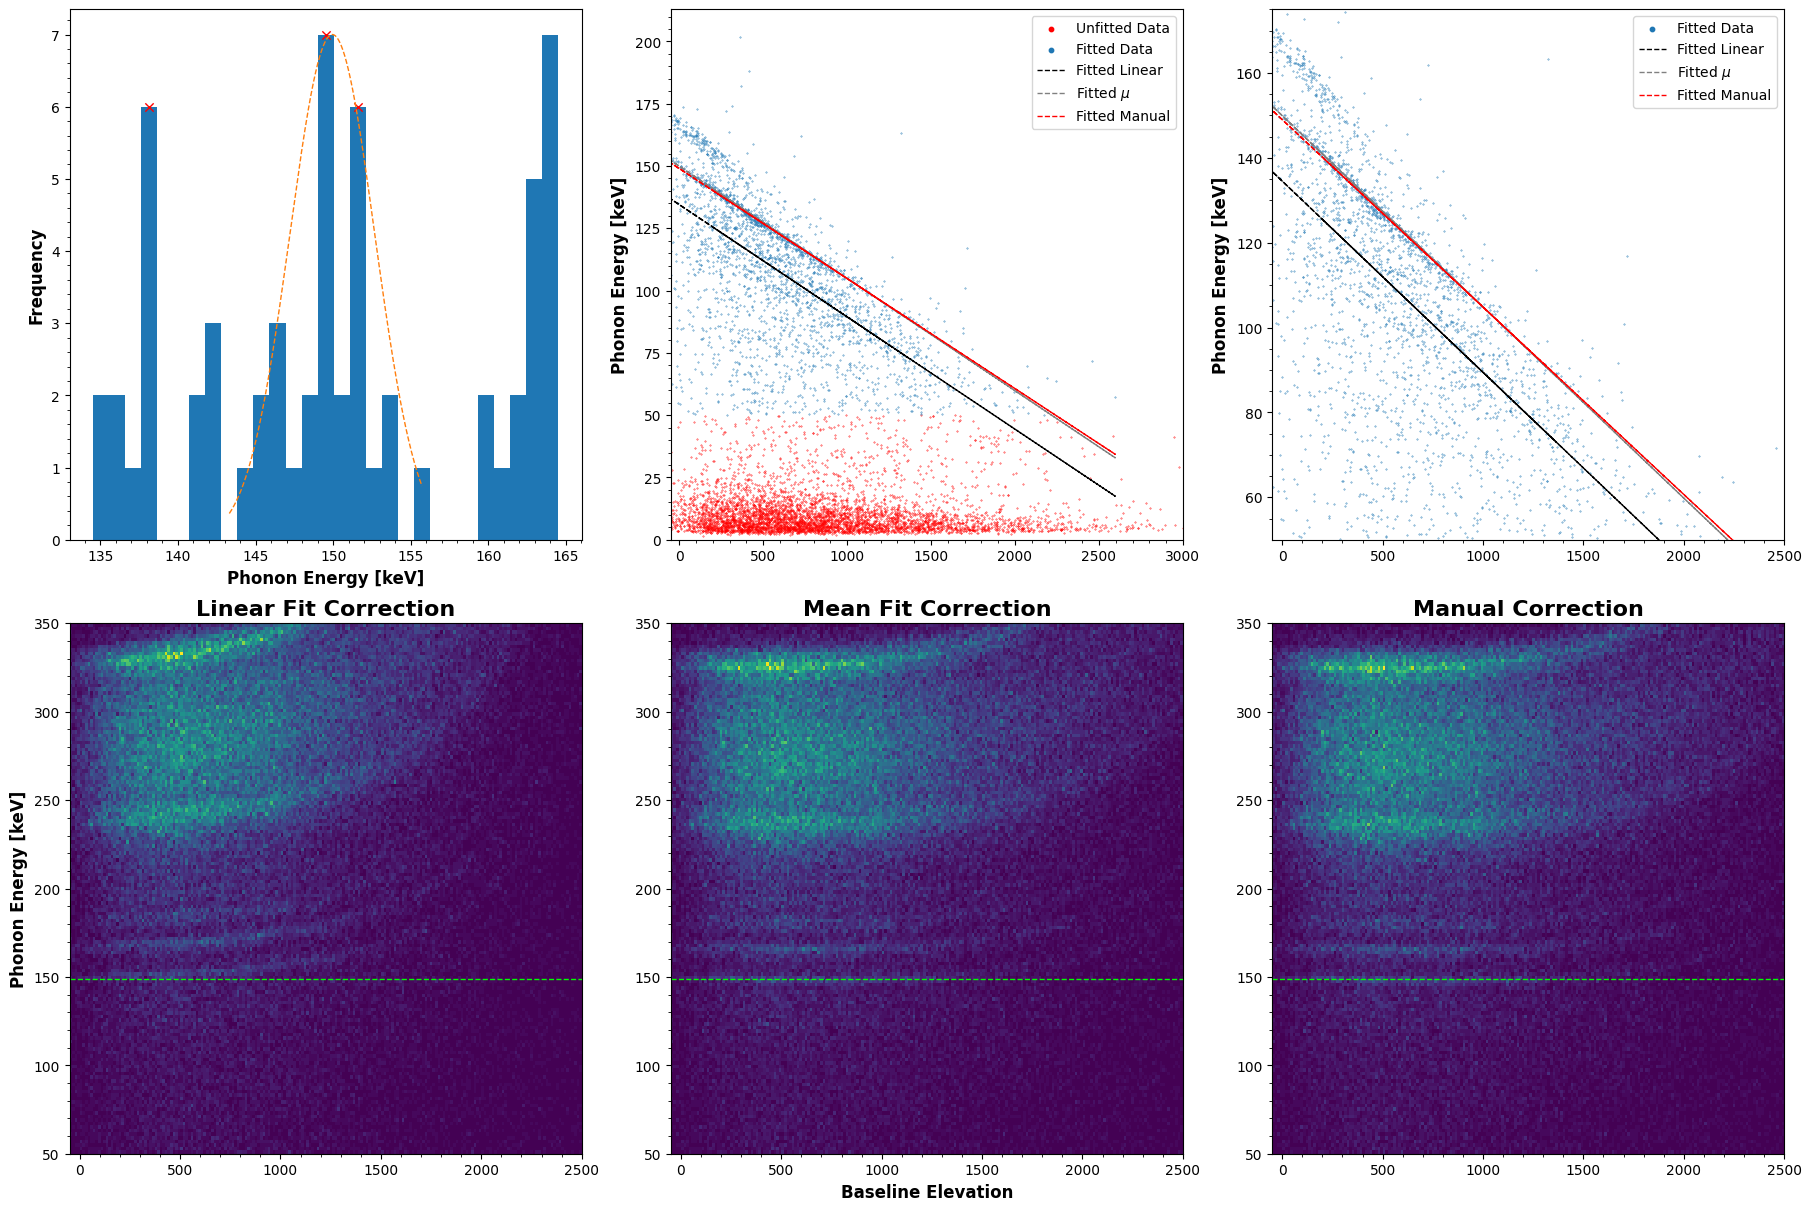

In [9]:
#Set up the histogram to seek data in
fig,ax = plt.subplots(2,3,figsize=(18,12))
#I think that the result will be systematically low due to noise, so I start at that value and move up
bins = np.linspace(fit.best_values['b'],fit.best_values['b']+30,30)
h = ax[0,0].hist(y[(x<50) & (x>-50)],bins=bins); hy = h[0]; hx = h[1] #Get hist values from the plot
hx = (hx[:-1]+hx[1:])/2

#Find the peaks
peaks, _ = sig.find_peaks(hy,height=np.mean(hy)+1) #Don't detect peaks beneath mean value
ax[0,0].scatter(hx[peaks],hy[peaks],marker="x",color="red")
#Set up and fit a gaussian near the median of all peaks. Scaled because hy is not normalized.
def gaussian(x,mu,sigma,A): return A*(2*np.pi)**(-1/2)/sigma*np.exp(-(x-mu)**2/(2*sigma**2))
modg = lf.Model(gaussian); paramsg = modg.make_params()
med = s.median(hx[peaks])
paramsg.add('mu',value=med,min=fit.best_values['b'],max=max(hx[peaks]))
paramsg.add('sigma',value=5,min=0)
paramsg.add('A',value=1,min=0,vary=False)
dist = hx[peaks][math.floor(len(peaks)/2)+1] - hx[peaks][math.floor(len(peaks)/2)] #get diff between medianish
rangemin = med-3*dist; rangemax = med+3*dist
rangeslice = (hx>=rangemin) & (hx<rangemax)
hyscaled = hy[rangeslice]/sum(hy[rangeslice])/(hx[1]-hx[0])
fitg = modg.fit(hyscaled,params=paramsg,x=hx[rangeslice])

#Plot our gaussian on our histogram
xs = np.linspace(rangemin,rangemax,1000); 
ys = gaussian(xs,fitg.best_values['mu'],fitg.best_values['sigma'],fitg.best_values['A']); 
ys *= max(hy)/max(ys)
ax[0,0].plot(xs,ys)
ax[0,0].set_xlabel("Phonon Energy [keV]"); ax[0,0].set_ylabel("Frequency")

#Compare gaussian to our previous fit.
ax[0,1].scatter(PSUMbs[~crand & cphi1 & cam & (pt_keV<50)]-18000,
            pt_keV[~crand & cphi1 & cam & (pt_keV<50)],
            s=0.1,color='red',label='Unfitted Data')
ax[0,1].scatter(x,y,s=0.1,label='Fitted Data')
ax[0,1].plot(x,fit.best_fit,color='k',label="Fitted Linear")
ax[0,1].plot(x,fit.best_values['m']*x+fitg.best_values['mu'],color='grey',label="Fitted $\mu$")
ax[0,1].plot(x,m*x+b,color='red',label='Fitted Manual')

ax[0,1].set_ylabel("Phonon Energy [keV]")
ax[0,1].set_xlim(-50,3000); ax[0,1].set_ylim(0)
ax[0,1].legend()

#Zoom in
ax[0,2].scatter(x,y,s=0.1,label='Fitted Data')
ax[0,2].plot(x,fit.best_fit,color='k',label="Fitted Linear")
ax[0,2].plot(x,fit.best_values['m']*x+fitg.best_values['mu'],color='grey',label="Fitted $\mu$")
ax[0,2].plot(x,m*x+b,color='red',label='Fitted Manual')

ax[0,2].set_ylabel("Phonon Energy [keV]")
ax[0,2].set_xlim(-50,2500); ax[0,2].set_ylim(50,175)
ax[0,2].legend()

#Now plot the two new corrections side-by-side

ax[1,0].set_title("Linear Fit Correction")
ax[1,1].set_title("Mean Fit Correction")
ax[1,2].set_title("Manual Correction")

L = fit.best_values['m']/fit.best_values['b']
G = fit.best_values['m']/fitg.best_values['mu']
z['bscorr_lin'] = pt_keV/(1.+(PSUMbs-18000.)*L)
z['bscorr_gau'] = pt_keV/(1.+(PSUMbs-18000.)*G)

ax[1,1].set_xlabel("Baseline Elevation") #suplabel is weirdly spaced
ax[1,0].set_ylabel("Phonon Energy [keV]")
ax[1,0].hist2d(PSUMbs[~crand]-18000,z["bscorr_lin"][~crand],
             bins=[np.linspace(-50,2500,200),np.linspace(50,350,150)])
ax[1,1].hist2d(PSUMbs[~crand]-18000,z["bscorr_gau"][~crand],
             bins=[np.linspace(-50,2500,200),np.linspace(50,350,150)])
ax[1,2].hist2d(PSUMbs[~crand]-18000,bscorr_man[~crand],
             bins=[np.linspace(-50,2500,200),np.linspace(50,350,150)])
for axs in ax[1]:
    axs.axhline(149,color='lime')
plt.show()

fitg

This version of the fit appears to work much better than the purely linear fit, but the manual correction is still better than both automated ones. Let's take a closer look:

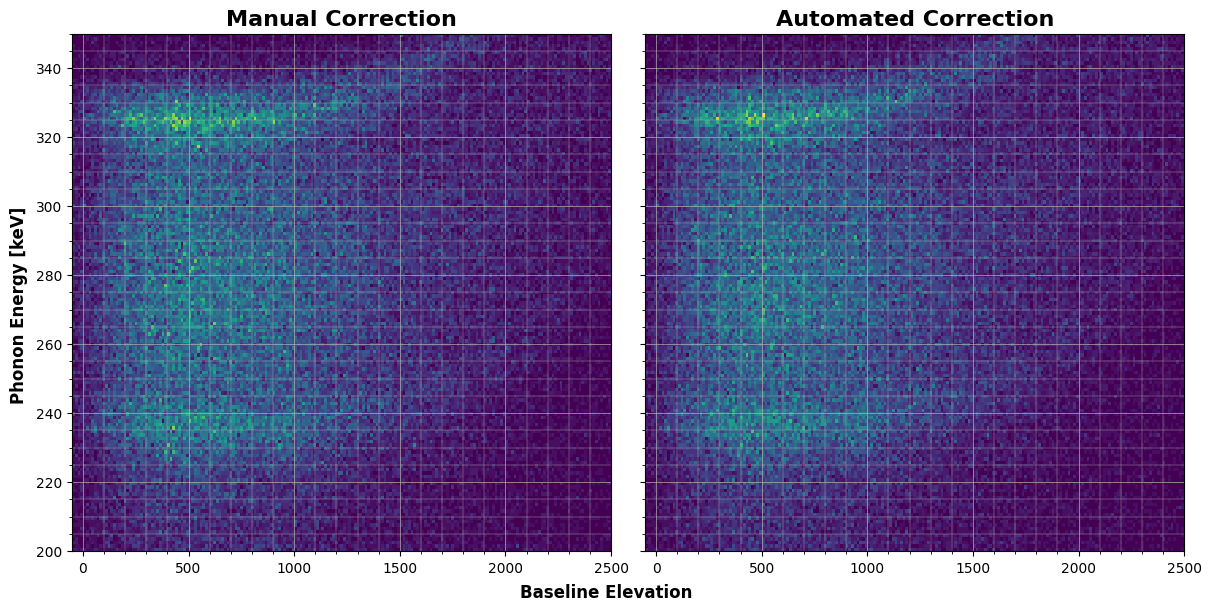

Linear fit coefficient: -0.00033504040847570936
With Gaussian: -0.00030056573432836985
Ratio L/G: 1.1146992827521573
% Difference: 0.10289706338463632


In [10]:
#Now plot it against the uncorrected version.
fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True) #set up plotting space

fig.supxlabel("Baseline Elevation")
fig.supylabel("Phonon Energy [keV]")
ax[1].hist2d(PSUMbs[~crand]-18000,z["bscorr_gau"][~crand],
             bins=[np.linspace(-50,2500,200),np.linspace(200,350,150)])
ax[0].hist2d(PSUMbs[~crand]-18000,bscorr_man[~crand],
             bins=[np.linspace(-50,2500,200),np.linspace(200,350,150)])
ax[0].set_title("Manual Correction")
ax[1].set_title("Automated Correction")

for axs in ax:
    axs.grid(True,which='minor',linewidth=0.3)
    axs.grid(True,which='major')
plt.show()

print("Linear fit coefficient:",L)
print("With Gaussian:",G)
print("Ratio L/G:",L/G)
print("% Difference:",(L-G)/L)